# 2. Pre-processing newly acquired training data

In [1]:
import re
import html
import random
import numpy as np
import polars as pl
from tqdm import tqdm
from langdetect import detect
import matplotlib.pyplot as plt
# from plotting_preferences_AS import plotting_preferences_AS

In [2]:
random.seed(894552352)
np.random.seed(894552352)
# plotting_preferences_AS()

In [3]:
train = pl.read_csv("./data/train.csv")

In [4]:
train["TEXT"][1]

'If she had only come to me and said she desired her freedom. If they had only both come together and faced me, saying that though it meant giving up all they had, they wanted only each other! I would have been generous. I would have been indulgent. But they did not. They had not the courage. They were afraid of me. And they hated me." [SNIPPET] Daddy was always shushing her.... But who was this big man in his dusty drab coveralls and dropped dust mask dangling upon his chest? "Don\'t you know me, Dear? It\'s Buhl, your husband." Buhl was fifteen and only a couple of inches taller than Ruth. Of course he had sandy hair like this man. But this man was old enough to be Buhl\'s father. This was crazy—like one of the dreams that always made her unhappy. So?'

The text form the provided training set is quite "clean," so similarly pre-processing 
the newly acquired data is important as it would improve tokenization and training.

### Assembling a pre-processing function  

In [5]:
def preprocess_text(
        text
):
    """
    Iteratively assembled with the aid of GPT-4o and using a test string with unwanted 
    string characters that may appear in the text such as links, excessive
    punctuation, emojis, et cetera.
    
    Prompt used: "Could you write a regex-based pre-processing function that filters 
    out {insert type of unwanted feature}?" For corrections, "I provided the function 
    this string 
    
    
    
    :param text: sentence as a string 
    :return: pre-preprocessed string 
    """
    # removing HTML or markup tags
    text = re.sub(r'<[^>]+>', '', text)  

    # removing HTML artifacts
    text = html.unescape(text) 

    # replacing underscores with spaces
    text = text.replace('_', ' ') 

    # removing URLs
    # text = re.sub(r'\[.*?\]\(.*?\)|http[s]?://\S+|www\.\S+', '', text)
    text = re.sub(
        r'\[.*?\]\(.*?\)|http[s]?://\S+|www\.\S+|\b[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}\b\S*', 
        ' ', 
        text
    )
    
    # replacing >2 repetitions of "-" with blank space
    text = re.sub(r'(-){3,}', ' ', text)

    # removing non-linguistic characters
    text = re.sub(r'[^\w\s.,!?\'\";:\-—\[\]()&<>/]', '', text)  
    # allowing "(, ), &, <, >, /" 

    # removing low-frequency or rare characters (non-ASCII)
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # normalizing punctuation
    text = re.sub(r'([!?.,])\1+', r'\1', text)

    # removing redundant whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

#### loading newly compiled training set 
(See `compiling_more_data.ipynb` for all the details.)

In [6]:
new_text_data = pl.read_csv("./data/refined/mega_txt_list.csv")

In [7]:
new_text_data["text"][0]

'Hello. I don\'t really know how to start this. I guess I\'ll tell you how I met my ex.\n\nRoughly 2 years ago, I was a patient in a psychiatric hospital. As a side note, I\'ve struggled with depression for most of my life, and have had alcohol dependency issues for many many years. While I was in the hospital, I met this girl. We talked a few times, and she told me that she was being treated for depression also, though she didn\'t seem very depressed at first. She told me stories about her "previous life" as a med student, and how she failed out of med school. I found myself drawn to her charms. Not much later, she left the facility because the treatment wasn\'t working for her. I gave her my number, and she texted me that same day. For 2 weeks, we would text all day, talking about everything; mostly how bored we were, she with her life at her apartment all alone, and I with the therapies. We realized that we really liked each other and went out on a date. Then another, and another. I

#### Spot checking text before and after pre-processing

In [8]:
for _ in range(5):
    random_index = random.randint(0, len(new_text_data))
    
    print("Original", "Index:", random_index)
    print(new_text_data["text"][random_index])
    
    print()
    
    print("Processed", "Index:", random_index)
    print(preprocess_text(new_text_data["text"][random_index]))
    
    print()
    print()

Original Index: 90376
“Like a fool, I went round to him just for a minute, on the way to see
Mitya, for he is ill, too, my Pole,” Grushenka began again with nervous
haste. “I was laughing, telling Mitya about it. ‘Fancy,’ I said, ‘my
Pole had the happy thought to sing his old songs to me to the guitar.
He thought I would be touched and marry him!’ Mitya leapt up
swearing.... So, there, I’ll send them the pies! Fenya, is it that
little girl they’ve sent? Here, give her three roubles and pack a dozen
pies up in a paper and tell her to take them. And you, Alyosha, be sure
to tell Mitya that I did send them the pies.”

Processed Index: 90376
Like a fool, I went round to him just for a minute, on the way to see Mitya, for he is ill, too, my Pole, Grushenka began again with nervous haste. I was laughing, telling Mitya about it. Fancy, I said, my Pole had the happy thought to sing his old songs to me to the guitar. He thought I would be touched and marry him! Mitya leapt up swearing. So, ther

In [9]:
new_text_data["text"][50720]

'Now this is the way to wrap up a series. We got time with each couple, saw their love and how good their lives have been, got to see them as a group and separated out, the men and women. It was nice to see the women stay strong when the guys were sent on a mission. \n The mission was interesting, from who they were going after, from how they found their quarry, to what happened afterward. \n The ending was great, I loved how we got to see each couple express their love and how the guys honored a new person they claimed into their group.'

There are some sequences with gibberish text. It seems that all this gibberish words 
have no vowel in between, so for all text sequences, if no-vowel words appear one after
 the other _n_ number of times, I will remove those rows from the dataframe.
 
### Removing gibberish from the texts

In [10]:
def remove_gibberish(text, threshold):
    vowel_set = set('aeiouAEIOU')
    words = text.split()
    
    # checking for vowels
    vowel_presence = [any(char in vowel_set for char in word) for word in words]
    
    # count if there are no-vowel words that appear sequentially
    count = 0
    for has_vowel in vowel_presence:
        if not has_vowel:
            count += 1
            if count >= threshold:
                return True
        else:
            count = 0
    return False

In [11]:
# cleaning the dataset
new_text_data = new_text_data.filter(
    ~new_text_data["text"].map_elements(lambda x: remove_gibberish(x, threshold=5))
)

/var/folders/25/8pnrgwt571b68wq6t25hql4w0000gn/T/ipykernel_76963/3974915693.py:3: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  ~new_text_data["text"].map_elements(lambda x: remove_gibberish(x, threshold=5))


In [12]:
# checking again

for _ in range(5):
    random_index = random.randint(0, len(new_text_data))
    
    print("Original", "Index:", random_index)
    print(new_text_data["text"][random_index])
    
    print()
    
    print("Processed", "Index:", random_index)
    print(preprocess_text(new_text_data["text"][random_index]))
    
    print()
    print()

Original Index: 78029
As to Squire Western, he happened at this time to be overtaken by an
enemy, which very frequently pursues, and seldom fails to overtake,
most of the country gentlemen in this kingdom. He was, literally
speaking, drunk; which circumstance, together with his natural
impetuosity, could produce no other effect than his running
immediately up to his daughter, upon whom he fell foul with his tongue
in the most inveterate manner; nay, he had probably committed violence
with his hands, had not the parson interposed, saying, “For heaven's
sake, sir, animadvert that you are in the house of a great lady. Let
me beg you to mitigate your wrath; it should minister a fulness of
satisfaction that you have found your daughter; for as to revenge, it
belongeth not unto us. I discern great contrition in the countenance
of the young lady. I stand assured, if you will forgive her, she will
repent her of all past offences, and return unto her duty.”

Processed Index: 78029
As to Squire 

Sufficiently good!

### Applying the pre-processing function

In [13]:
# preprocessing all the text
preprocessed_text = list(map(preprocess_text, new_text_data["text"].to_list()))
preprocessed_text_length = [len(i) for i in preprocessed_text]
preprocessed_text_source = new_text_data["source"].to_list()

In [14]:
len(preprocessed_text)

90539

In [15]:
# some sentences may have fallen below 300 characters, so removing those
preprocessed_text_ll = list(
    [source, sentence, length] for source, sentence, length in zip(
        preprocessed_text_source, preprocessed_text, preprocessed_text_length
    ) if length > 300
)

len(preprocessed_text_ll)

90307

In [16]:
# re-checking and removing non-English text
preprocessed_text_ll = list(
    [source, sentence, length] for source, sentence, length in preprocessed_text_ll
    if detect(sentence) == "en"
)

len(preprocessed_text_ll)

90306

In [17]:
# checking what lazily halving the text looks like
preprocessed_text_ll[65703][1][:len(preprocessed_text_ll[65703][1]) // 2]

'Thou first, great Ajax! on the unsanguined plain Laid Hyrtius, leader of the Mysian train. Phalces and Mermer, Nestors son oerthrew, Bold Merion, Morys and Hippotion slew. Strong Periphaetes and Prothoon bled, By Teucers arrows mingled with the dead, Pierced in the flank by Menelaus steel, Hi'

### Splitting the sentences into two halves

In the loop below:
1. The sentence is split if there is a "." around the middle length ($\pm$50 characters)
2. If no period is found in that range, then the sentence is split if there is space $\pm$15 characters around the middle
3. If there is no space between words in that range, the sentence is split around the middle

In [36]:
source_of_text = []
half_splits = []
label = []
first_half_length = []
second_half_length = []
lazy_split_bool = []

# this loop sweeps through a sentence and roughly splits them in half
# (there is a smarter way to write this loop as a recursive function)
for stuff in tqdm(preprocessed_text_ll):
    source, text, _ = stuff

    min_sweep = len(text) // 2 - 50
    max_sweep = len(text) // 2 + 50
    window = 1

    sweep = min_sweep
    
    inside_inner_loop = False
    while True:
        if text[sweep:sweep + window] == ".":
            source_of_text.append(source)
            
            # saving the splits
            half_splits.append([
                text[:sweep + window],
                text[sweep + window:],
            ])
            
            # label = 1 indicates that the two halves are from the same author
            label.append(1)
            
            first_half_length.append(len(text[:sweep + window]))
            second_half_length.append(len(text[sweep + window:]))
            lazy_split_bool.append(False)

            break
            
        if sweep + window == max_sweep:
            inside_inner_loop = True
            
            min_sweep = len(text) // 2 - 15 # 100
            max_sweep = len(text) // 2 + 15 # 250
            
            sweep2 = min_sweep
            
            while True:
                if text[sweep2:sweep2 + window] == " ":
                    # print("here", sweep2 + window)
                    source_of_text.append(source)
                    
                    half_splits.append([
                        text[:sweep2 + window],
                        text[sweep2 + window:],
                    ])
                            
                    # label = 1 indicates that the two halves are from the same author
                    label.append(1)
                    
                    first_half_length.append(len(text[:sweep2 + window]))
                    second_half_length.append(len(text[sweep2 + window:]))
                    lazy_split_bool.append(False)
            
                    break
                
                # print(sweep2 + window == max_sweep)
                
                # There may be some sentences aren't separated by periods
                # in such cases, I lazily split the sentences in the middle
                # I am storing which ones are lazily split, so I can remove them later if needed
                if sweep2 + window == max_sweep:
                    source_of_text.append(source)
                    
                    half_splits.append([
                        text[:len(text) // 2],
                        text[len(text) // 2:],
                    ])
                    
                    # label = 1 indicates that the two halves are from the same author
                    label.append(1)
                    
                    first_half_length.append(len(text[:len(text) // 2]))
                    second_half_length.append(len(text[len(text) // 2:]))
                    lazy_split_bool.append(True)
                    
                    break
                
                sweep2 += 1
            
        if inside_inner_loop:
            break
            
        sweep += 1

100%|██████████| 90306/90306 [00:00<00:00, 93972.55it/s] 


In [37]:
len([i for i in lazy_split_bool if i is True])

0

Perfect, none of the sentences were lazily split!

In [38]:
# number of super short sentence halves 
# in the first and second halves, respectively
print(
    len([i for i in first_half_length if i < 200]),
    len([i for i in second_half_length if i < 200]),
)

1666 1174


In [39]:
num_short_sentences = len([i for i, j in zip(
        first_half_length, second_half_length
    ) if i < 200 or j < 200])

print(
    "Total number of super short sentence pairs:",
    num_short_sentences
)

Total number of super short sentence pairs: 2098


Super short sentences may not have enough context and writing flavor for the model to 
identify authorship, and there aren't that many of them, so I will remove them later.

In [40]:
# number of sentences from reddit
len([i for i in source_of_text if i[-4:] == ".csv"])

12010

I __may__ also remove all reddit data (~12,000 data points) as they tend to be noisy. 

There are some sentences with high quality signal within them, but it is not worth 
hunting and pecking for them.

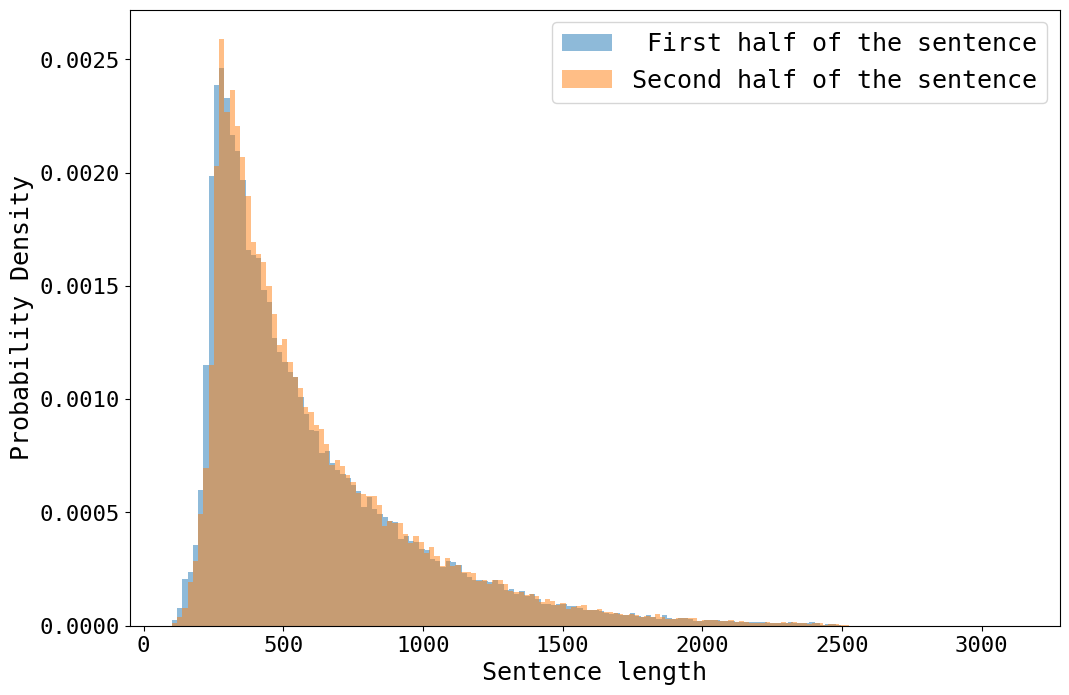

In [41]:
# checking if the split sentence lengths are roughly equal
plt.hist(
    first_half_length, 
    bins="fd",
    alpha=0.5,
    density=True,
    label=" First half of the sentence"
)

plt.hist(
    second_half_length, 
    bins="fd",
    alpha=0.5,
    density=True,
    label="Second half of the sentence"
)

plt.xlabel("Sentence length")
plt.ylabel("Probability Density")

plt.legend(fontsize=18)
# plt.show()

# ADD spline adjustment later if time allows
plt.savefig(
    "./plots/sentence_half_lengths.png",
    dpi=300,
    bbox_inches="tight"
)

In [42]:
df_to_clean_full = pl.DataFrame({
    "source": source_of_text,
    "first_half": [i[0] for i in half_splits],
    "second_half": [i[1] for i in half_splits],
    "label": label,
    "first_half_length": first_half_length,
    "second_half_length": second_half_length
})

print(df_to_clean_full)

shape: (90_306, 6)
┌──────────────────┬─────────────────┬─────────────────┬───────┬─────────────────┬─────────────────┐
│ source           ┆ first_half      ┆ second_half     ┆ label ┆ first_half_leng ┆ second_half_len │
│ ---              ┆ ---             ┆ ---             ┆ ---   ┆ th              ┆ gth             │
│ str              ┆ str             ┆ str             ┆ i64   ┆ ---             ┆ ---             │
│                  ┆                 ┆                 ┆       ┆ i64             ┆ i64             │
╞══════════════════╪═════════════════╪═════════════════╪═══════╪═════════════════╪═════════════════╡
│ suicidewatch_dat ┆ Hello. I don't  ┆ I found it so   ┆ 1     ┆ 2308            ┆ 2371            │
│ a.csv            ┆ really know     ┆ quickly that I  ┆       ┆                 ┆                 │
│                  ┆ how…            ┆ …               ┆       ┆                 ┆                 │
│ suicidewatch_dat ┆ I don't know    ┆ It just         ┆ 1     ┆ 1631   

In [43]:
# filtering super short sentences
df_short_removed = df_to_clean_full.filter(
    ~((pl.col("first_half_length") < 200) | (pl.col("second_half_length") < 200))
)

print(len(df_short_removed))
print(len(df_short_removed) == len(df_to_clean_full) - num_short_sentences)

88208
True


In [44]:
# removing duplicated texts
df_short_dup_removed = df_short_removed.filter(
    ~df_short_removed["first_half"].is_duplicated() & ~df_short_removed["second_half"].is_duplicated()
)

In [45]:
print(len(df_short_removed)- len(df_short_dup_removed))

891


In [46]:
len(df_short_dup_removed)

87317

### Performing sentence pair swaps

In [47]:
unique_authors_barring_reddit = np.unique(
    [i for i in df_short_dup_removed["source"] if i[-4:] != ".csv"]
) 

print(
    "Number of unique non-reddit authors:",
    len(unique_authors_barring_reddit)
)

Number of unique non-reddit authors: 94


In [48]:
author_type = []

for i in df_short_dup_removed["source"]:
    if i[-4:] == ".txt":
        author_type.append("book")
    elif i[-4:] == ".csv":
        author_type.append("reddit")
    else:
        author_type.append("goodreads")

print(len(author_type) == len(df_short_dup_removed))

True


In [49]:
df_short_dup_removed.insert_column(
    0, 
    pl.Series(
        "source_type",
        author_type,
    )
)

source_type,source,first_half,second_half,label,first_half_length,second_half_length
str,str,str,str,i64,i64,i64
"""reddit""","""suicidewatch_data.csv""","""Hello. I don't really know how…",""" I found it so quickly that I …",1,2308,2371
"""reddit""","""suicidewatch_data.csv""","""I don't know what to say or do…",""" It just reflected how after a…",1,1631,1667
"""reddit""","""suicidewatch_data.csv""",""". and was asked to please 'wat…","""shift (heh -- suicide hotline;…",1,208,234
"""reddit""","""suicidewatch_data.csv""","""I saw it on twitter. Multiple …",""" There is true evil in this wo…",1,390,484
"""reddit""","""suicidewatch_data.csv""","""If you say you're so depressed…",""" I've been serious all along. …",1,355,291
…,…,…,…,…,…,…
"""book""","""Doctrina Christiana .txt""","""Receiving bread from us, they …",""" They will marvel at us and wi…",1,1281,1294
"""book""","""Doctrina Christiana .txt""","""The most painful secrets of th…","""her hands the mystery , shall …",1,1191,1218
"""book""","""Doctrina Christiana .txt""","""I know you would all like it t…",""" I tell you that, the boy was …",1,1271,1363


In [50]:
df_minus_reddit = df_short_dup_removed.filter(~(pl.col("source_type") == "reddit"))

In [51]:
df_dictionary = df_minus_reddit.to_dict()
df_dictionary.keys()

dict_keys(['source_type', 'source', 'first_half', 'second_half', 'label', 'first_half_length', 'second_half_length'])

In [52]:
len(df_dictionary["label"]) == len(df_minus_reddit)

True

In [77]:
swaps = 0
total_swaps = len(df_minus_reddit) // 4  
indices_swapped = set() 

with tqdm(total=total_swaps, desc="Swaps done") as pbar:
    while swaps < total_swaps:
        # randomly choosing two distinct indices
        index1, index2 = random.sample(range(len(df_minus_reddit)), 2)
        
        # swaps only for books and goodreads and if the authors are different
        if (
                index1 != index2 
                and index1 not in indices_swapped 
                and index2 not in indices_swapped
                and df_dictionary["source"][index1] != df_dictionary["source"][index2]
                and df_dictionary["source_type"][index1] == df_dictionary["source_type"][index2]
                # and df_dictionary["source"][index1][-4:] != ".csv"
                # and df_dictionary["source"][index1][-4:] != ".csv"   
        ):
            
            len_idx1 = len(df_dictionary["second_half"][index1])
            len_idx2 = len(df_dictionary["second_half"][index2])
            
            if np.abs(len_idx1 - len_idx2) / len_idx1 < 1:
                # performing the swaps
                (
                    df_dictionary["second_half"][index1], 
                    df_dictionary["second_half"][index2]
                ) = (
                    df_dictionary["second_half"][index2], 
                    df_dictionary["second_half"][index1]
                )
                
                # updating the labels
                # 0 = different authors
                df_dictionary["label"][index1] = 0
                df_dictionary["label"][index2] = 0
            
                # recording indices that have been swapped so 
                # that they aren't chosen a second time
                indices_swapped.add(index1)
                indices_swapped.add(index2)
                
                # updating the progress bar
                swaps += 1
                pbar.update(1)

Swaps done: 100%|██████████| 19431/19431 [03:38<00:00, 88.91it/s] 


In [78]:
unmatched_num = len([i for i in df_dictionary['label'] if i == 0])

print(
    f"The new acquired data has "
    f"{100 * np.round((unmatched_num / len(df_minus_reddit)), 4)}"
    f"% unmatched sentences."
)

The new acquired data has 50.0% unmatched sentences.


##### Now, swapping text written by the same authors

In [82]:
swaps = 0
total_swaps = len(df_minus_reddit) // 7
indices_swapped = set() 

with tqdm(total=total_swaps, desc="Swaps done") as pbar:
    while swaps < total_swaps:
        # randomly choosing two distinct indices
        index1, index2 = random.sample(range(len(df_minus_reddit)), 2)
        
        # swaps only for books and goodreads and if the authors are different
        if (
                index1 != index2 
                and index1 not in indices_swapped 
                and index2 not in indices_swapped
                and df_dictionary["source"][index1] == df_dictionary["source"][index2]
        ):
            len_idx1 = len(df_dictionary["second_half"][index1])
            len_idx2 = len(df_dictionary["second_half"][index2])
            
            len_idx1_ = len(df_dictionary["first_half"][index1])
            len_idx2_ = len(df_dictionary["first_half"][index2])
            
            if np.abs(len_idx1 - len_idx2) / len_idx1 < 1:
                if np.abs(len_idx1_ - len_idx2_) / len_idx1_ < 1:
                    # performing the swaps
                    (
                        df_dictionary["second_half"][index1], 
                        df_dictionary["second_half"][index2]
                    ) = (
                        df_dictionary["second_half"][index2], 
                        df_dictionary["second_half"][index1]
                    )
                    
                    if np.random.choice([1, 2, 3, 4]).item() == 3:
                        (
                            df_dictionary["first_half"][index1], 
                            df_dictionary["second_half"][index1]
                        ) = (
                            df_dictionary["second_half"][index1], 
                            df_dictionary["first_half"][index1]
                        )
                        
                        (
                            df_dictionary["first_half"][index2], 
                            df_dictionary["second_half"][index2]
                        ) = (
                            df_dictionary["second_half"][index2], 
                            df_dictionary["first_half"][index2]
                        )
                    
                    # recording indices that have been swapped so 
                    # that they aren't chosen a second time
                    indices_swapped.add(index1)
                    indices_swapped.add(index2)
                    
                    # updating the progress bar
                    swaps += 1
                    pbar.update(1)

Swaps done: 100%|██████████| 11103/11103 [03:14<00:00, 57.21it/s]


In [83]:
df_dictionary_df = pl.DataFrame(df_dictionary)
df_dictionary_df

source_type,source,first_half,second_half,label,first_half_length,second_half_length
str,str,str,str,i64,i64,i64
"""goodreads""","""843a44e2499ba9362b47a089b0b0ce…","""I don't know what it is about …",""" In this book the school is pu…",0,551,577
"""goodreads""","""9003d274774f4c47e62f77600b08ac…","""When five-year-old Kioko final…",""" This book will probably be pr…",0,317,253
"""goodreads""","""422e76592e2717d5d59465d22d74d4…","""wanted the downtrodden princes…","""Slick's review posted on Guilt…",0,1018,1043
"""goodreads""","""422e76592e2717d5d59465d22d74d4…",""" The first scene in the book w…","""Angeline's review posted at Gu…",0,590,675
"""goodreads""","""b7772313835ce6257a3fbe7ad2649a…","""I loved Jake there's only so m…","""in hyperbolic fashion here, ne…",0,237,331
…,…,…,…,…,…,…
"""book""","""Doctrina Christiana .txt""","""Receiving bread from us, they …",""" He recognized the fact that o…",0,1281,1294
"""book""","""Doctrina Christiana .txt""","""The most painful secrets of th…","""to our Saviour, ""Thou art Chri…",0,1191,1218
"""book""","""Doctrina Christiana .txt""","""I know you would all like it t…",""" I tell you that, the boy was …",1,1271,1363


In [84]:
less_common_authors = (
    df_dictionary_df.select("source")
    .group_by("source")
    .count()
    .sort(by="count") #, descending=True)
 )[:30]["source"].to_list()

/var/folders/25/8pnrgwt571b68wq6t25hql4w0000gn/T/ipykernel_76963/538083436.py:4: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


In [85]:
few_more_common_authors = (
    df_dictionary_df.select("source")
    .group_by("source")
    .count()
    .sort(by="count", descending=True)
 )[18:23]["source"].to_list()

/var/folders/25/8pnrgwt571b68wq6t25hql4w0000gn/T/ipykernel_76963/2424161683.py:4: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  .count()


In [86]:
authors_in_validation = less_common_authors + few_more_common_authors
len(authors_in_validation)

35

In [87]:
# combining sentence halves with "[SNIPPET]" in between
df_dictionary_df = df_dictionary_df.with_columns(
    pl.concat_str(
        [pl.col("first_half"), pl.lit(" [SNIPPET] "), pl.col("second_half")]
    ).alias("TEXT")
)

df_dictionary_df

source_type,source,first_half,second_half,label,first_half_length,second_half_length,TEXT
str,str,str,str,i64,i64,i64,str
"""goodreads""","""843a44e2499ba9362b47a089b0b0ce…","""I don't know what it is about …",""" In this book the school is pu…",0,551,577,"""I don't know what it is about …"
"""goodreads""","""9003d274774f4c47e62f77600b08ac…","""When five-year-old Kioko final…",""" This book will probably be pr…",0,317,253,"""When five-year-old Kioko final…"
"""goodreads""","""422e76592e2717d5d59465d22d74d4…","""wanted the downtrodden princes…","""Slick's review posted on Guilt…",0,1018,1043,"""wanted the downtrodden princes…"
"""goodreads""","""422e76592e2717d5d59465d22d74d4…",""" The first scene in the book w…","""Angeline's review posted at Gu…",0,590,675,""" The first scene in the book w…"
"""goodreads""","""b7772313835ce6257a3fbe7ad2649a…","""I loved Jake there's only so m…","""in hyperbolic fashion here, ne…",0,237,331,"""I loved Jake there's only so m…"
…,…,…,…,…,…,…,…
"""book""","""Doctrina Christiana .txt""","""Receiving bread from us, they …",""" He recognized the fact that o…",0,1281,1294,"""Receiving bread from us, they …"
"""book""","""Doctrina Christiana .txt""","""The most painful secrets of th…","""to our Saviour, ""Thou art Chri…",0,1191,1218,"""The most painful secrets of th…"
"""book""","""Doctrina Christiana .txt""","""I know you would all like it t…",""" I tell you that, the boy was …",1,1271,1363,"""I know you would all like it t…"


In [88]:
# renaming label to LABEL
df_dictionary_df = df_dictionary_df.rename({"label": "LABEL",})

In [89]:
# adding an ID columns with serial indices
df_dictionary_df.insert_column(
    0, 
    pl.Series(
        "ID",
        list(np.random.randint(100000, 999999) for _ in range(len(df_dictionary_df))),
    )
)

df_dictionary_df.head()

ID,source_type,source,first_half,second_half,LABEL,first_half_length,second_half_length,TEXT
i64,str,str,str,str,i64,i64,i64,str
427855,"""goodreads""","""843a44e2499ba9362b47a089b0b0ce…","""I don't know what it is about …",""" In this book the school is pu…",0,551,577,"""I don't know what it is about …"
419516,"""goodreads""","""9003d274774f4c47e62f77600b08ac…","""When five-year-old Kioko final…",""" This book will probably be pr…",0,317,253,"""When five-year-old Kioko final…"
279521,"""goodreads""","""422e76592e2717d5d59465d22d74d4…","""wanted the downtrodden princes…","""Slick's review posted on Guilt…",0,1018,1043,"""wanted the downtrodden princes…"
996684,"""goodreads""","""422e76592e2717d5d59465d22d74d4…",""" The first scene in the book w…","""Angeline's review posted at Gu…",0,590,675,""" The first scene in the book w…"
289712,"""goodreads""","""b7772313835ce6257a3fbe7ad2649a…","""I loved Jake there's only so m…","""in hyperbolic fashion here, ne…",0,237,331,"""I loved Jake there's only so m…"


In [90]:
df_dictionary_df.filter(pl.col("LABEL") == 1)["TEXT"][0]

"Kampung Boy (Budak Kampung) is an autobiography in the form of a graphic novel. It covers Lat's childhood in the 1950s and 1960s in a village in the Kinta Valley. It starts with his birth and ends with his father riding with him to the boarding school as a teen. I found this book tucked between a number of manga series at my local library. I was drawn in by the title and the publisher / importer: :01 (same publisher as Life Sucks). I flipped through the book, liked the art style and found the first few pages captivating. [SNIPPET]  Stylistically Kampung Boy reminds me most of Three Shadows by Cyril Pedrosa (another :01 import) (). There's a similarity with the jutting jaws, wiggly legs and the basic energy of all the characters (especially the children). What's thankfully missing from Kampung Boy is the underlying tragedy of Three Shadows. Besides being a fun coming of age story, Kampung Boy was educational for me. I went into the book knowing next to nothing about Malaysia. I came aw

### Creating and saving training and validation sets

In [91]:
new_training_set = df_dictionary_df.filter(
    ~(pl.col("source").is_in(authors_in_validation))
)

len(new_training_set)

70729

In [92]:
new_training_set = new_training_set.sample(fraction=1, shuffle=True, seed=894552352)
new_training_set.write_csv(
    "./data/improved_train.csv"
)

In [93]:
new_validation_set = df_dictionary_df.filter(
    pl.col("source").is_in(authors_in_validation)
)

new_validation_set = new_validation_set.sample(fraction=1, shuffle=True, seed=894552352)
new_validation_set.write_csv(
    "./data/improved_val.csv"
)

In [94]:
len(new_training_set) + len(new_validation_set) == len(df_dictionary_df)

True